# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/train",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/cherry-leaves/test",
    label_mode="categorical",
    class_names=['healthy','powdery_mildew'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4205 files belonging to 2 classes.
==========================Validation Data====================
Found 1574 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/cherry-leaves/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/cherry-leaves/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4205 images belonging to 2 classes.
Found 1574 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Sat May 27 21:02:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P0               39W /  N/A|   4593MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.7969
Epoch 1: val_accuracy improved from -inf to 0.99365, saving model to Cherry_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


211/211 [==============================] - 36s 159ms/step - loss: 0.4430 - accuracy: 0.7969 - val_loss: 0.0396 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9646
Epoch 2: val_accuracy did not improve from 0.99365
211/211 [==============================] - 31s 147ms/step - loss: 0.1046 - accuracy: 0.9646 - val_loss: 0.0751 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9684
Epoch 3: val_accuracy did not improve from 0.99365
211/211 [==============================] - 31s 147ms/step - loss: 0.0899 - accuracy: 0.9684 - val_loss: 0.1442 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 4/100
211/211 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.9888
Epoch 4: val_accuracy did not improve from 0.99365
211/211 [==============================] - 31s 147ms/step - loss: 0.0415 - accuracy: 0.9888 - val_loss: 0.0618 - va

INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


211/211 [==============================] - 34s 160ms/step - loss: 0.0519 - accuracy: 0.9845 - val_loss: 0.0208 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 6/100
211/211 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9748
Epoch 6: val_accuracy did not improve from 0.99619
211/211 [==============================] - 31s 146ms/step - loss: 0.0677 - accuracy: 0.9748 - val_loss: 0.0996 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 7/100
211/211 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9836
Epoch 7: val_accuracy improved from 0.99619 to 0.99682, saving model to Cherry_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


211/211 [==============================] - 34s 163ms/step - loss: 0.0450 - accuracy: 0.9836 - val_loss: 0.0186 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 8/100
211/211 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9886
Epoch 8: val_accuracy did not improve from 0.99682
211/211 [==============================] - 30s 142ms/step - loss: 0.0435 - accuracy: 0.9886 - val_loss: 0.0841 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 9/100
211/211 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9919
Epoch 9: val_accuracy did not improve from 0.99682
211/211 [==============================] - 30s 144ms/step - loss: 0.0322 - accuracy: 0.9919 - val_loss: 0.0226 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 10/100
211/211 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9910
Epoch 10: val_accuracy did not improve from 0.99682
211/211 [==============================] - 34s 160ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 0.0521 - 

INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model1_Based_Augmented\assets


211/211 [==============================] - 36s 170ms/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 5.7386e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 12/100
211/211 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9900
Epoch 12: val_accuracy did not improve from 1.00000
211/211 [==============================] - 31s 148ms/step - loss: 0.0280 - accuracy: 0.9900 - val_loss: 0.0289 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 13/100
211/211 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9943
Epoch 13: val_accuracy did not improve from 1.00000
211/211 [==============================] - 32s 149ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.0355 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 14/100
211/211 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9879
Epoch 14: val_accuracy did not improve from 1.00000
211/211 [==============================] - 31s 147ms/step - loss: 0.0473 - accuracy: 0.9879 - val_loss: 0

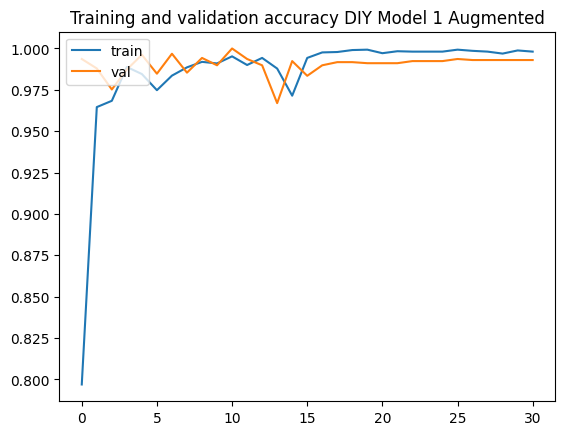

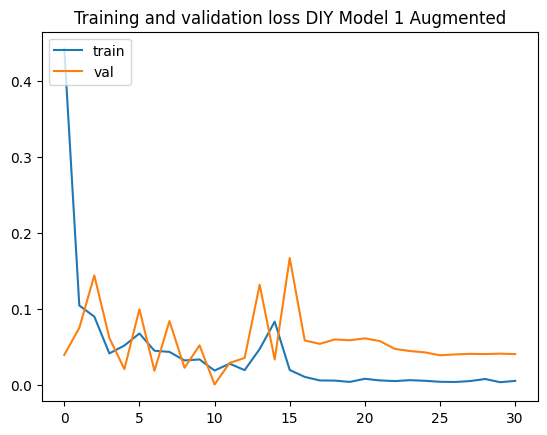

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 1 Augmented')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Cherry_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8666
Epoch 1: val_accuracy improved from -inf to 0.59212, saving model to Cherry_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 36s 168ms/step - loss: 0.3426 - accuracy: 0.8666 - val_loss: 1.5584 - val_accuracy: 0.5921 - lr: 0.0010
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.2009 - accuracy: 0.9265
Epoch 2: val_accuracy improved from 0.59212 to 0.95362, saving model to Cherry_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 34s 161ms/step - loss: 0.2009 - accuracy: 0.9265 - val_loss: 0.1888 - val_accuracy: 0.9536 - lr: 0.0010
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9731
Epoch 3: val_accuracy improved from 0.95362 to 0.98793, saving model to Cherry_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 35s 164ms/step - loss: 0.0822 - accuracy: 0.9731 - val_loss: 0.0713 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 4/100
211/211 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9753
Epoch 4: val_accuracy did not improve from 0.98793
211/211 [==============================] - 31s 146ms/step - loss: 0.0810 - accuracy: 0.9753 - val_loss: 0.1369 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 5/100
211/211 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9855
Epoch 5: val_accuracy did not improve from 0.98793
211/211 [==============================] - 31s 146ms/step - loss: 0.0464 - accuracy: 0.9855 - val_loss: 0.0704 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 6/100
211/211 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9812
Epoch 6: val_accuracy did not improve from 0.98793
211/211 [==============================] - 33s 154ms/step - loss: 0.0666 - accuracy: 0.9812 - val_loss: 0.0809 - va

INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 37s 175ms/step - loss: 0.0761 - accuracy: 0.9788 - val_loss: 0.0295 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 9/100
211/211 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9879
Epoch 9: val_accuracy did not improve from 0.99238
211/211 [==============================] - 31s 148ms/step - loss: 0.0420 - accuracy: 0.9879 - val_loss: 0.0427 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 10/100
211/211 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9924
Epoch 10: val_accuracy improved from 0.99238 to 0.99428, saving model to Cherry_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 38s 180ms/step - loss: 0.0284 - accuracy: 0.9924 - val_loss: 0.0250 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 11/100
211/211 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9924
Epoch 11: val_accuracy did not improve from 0.99428
211/211 [==============================] - 32s 152ms/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.0501 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 12/100
211/211 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9912
Epoch 12: val_accuracy did not improve from 0.99428
211/211 [==============================] - 32s 151ms/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 0.0692 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 13/100
211/211 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9936
Epoch 13: val_accuracy did not improve from 0.99428
211/211 [==============================] - 32s 152ms/step - loss: 0.0244 - accuracy: 0.9936 - val_loss: 0.045

INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 38s 182ms/step - loss: 0.0500 - accuracy: 0.9817 - val_loss: 0.0342 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 15/100
211/211 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9924
Epoch 15: val_accuracy did not improve from 0.99746

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
211/211 [==============================] - 32s 151ms/step - loss: 0.0237 - accuracy: 0.9924 - val_loss: 0.0285 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 16/100
211/211 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9981
Epoch 16: val_accuracy did not improve from 0.99746
211/211 [==============================] - 31s 146ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.0158 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 17/100
211/211 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9986
Epoch 17: val_accuracy did not improve from 0.99746
211/211 [=================

INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 40s 188ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0025 - val_accuracy: 0.9987 - lr: 1.0000e-04
Epoch 25/100
211/211 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9998
Epoch 25: val_accuracy did not improve from 0.99873
211/211 [==============================] - 34s 162ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0237 - val_accuracy: 0.9962 - lr: 1.0000e-04
Epoch 26/100
211/211 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9986
Epoch 26: val_accuracy did not improve from 0.99873
211/211 [==============================] - 33s 154ms/step - loss: 0.0038 - accuracy: 0.9986 - val_loss: 0.0102 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 27/100
211/211 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990
Epoch 27: val_accuracy did not improve from 0.99873
211/211 [==============================] - 32s 153ms/step - loss: 0.0033 - accuracy: 0.9990 - val

INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: Cherry_DIY_model2_Based_Augmented\assets


211/211 [==============================] - 41s 196ms/step - loss: 0.0018 - accuracy: 0.9990 - val_loss: 0.0028 - val_accuracy: 0.9994 - lr: 1.0000e-04
Epoch 29/100
211/211 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998
Epoch 29: val_accuracy did not improve from 0.99936

Epoch 29: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
211/211 [==============================] - 33s 155ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0078 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 30/100
211/211 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 30: val_accuracy did not improve from 0.99936
211/211 [==============================] - 31s 149ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0061 - val_accuracy: 0.9987 - lr: 1.0000e-05
Epoch 31/100
211/211 [==============================] - ETA: 0s - loss: 6.5880e-04 - accuracy: 1.0000
Epoch 31: val_accuracy did not improve from 0.99936
211/211 [=====

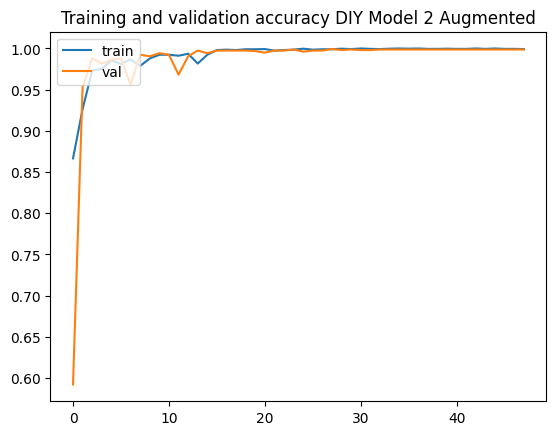

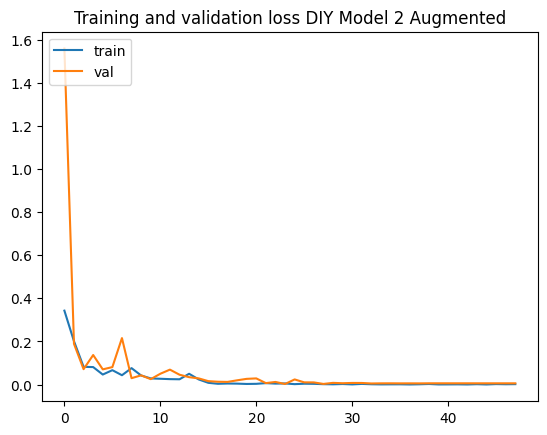

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model 2 Augmented')
plt.legend(['train', 'val'], loc='upper left')